# Calibrating the MATILDA framework

In this notebook we will

1. ... set up a glacio-hydrological model with all the data we have collected,

2. ... run the model for the calibration period with default parameters and check the results,

3. ... use a statistical parameter optimization routine to calibrate the model,

4. ... and store the calibrated parameter set for the scenario runs in the next notebook.


The framework for Modeling water resources in glacierized catchments [MATILDA] (https://github.com/cryotools/matilda) has been developed for use in this workflow and is published as a Python package. It is based on the widely used [HBV hydrological model](https://www.cabdirect.org/cabdirect/abstract/19961904773), complemented by a temperature-index glacier melt model based on the code of [Seguinot (2019)](https://zenodo.org/record/3467639). Glacier evolution over time is simulated using a modified version of the &Delta;*h* approach following [Seibert et. al. (2018)](https://doi.org/10.5194/hess-22-2211-2018).

As before we start by loading configurations such as the calibration period and some helper functions to work with  `yaml` files.

In [1]:
from tools.helpers import update_yaml, read_yaml, write_yaml
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get output dir and date range from config.ini
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
date_range = ast.literal_eval(config['CONFIG']['DATE_RANGE'])

print('MATILDA will be calibrated on the period ' + date_range[0] + ' to ' + date_range[1])

MATILDA will be calibrated on the period 1998-01-01 to 2020-12-31


Since HBV is a so-called 'bucket' model and all the buckets are empty in the first place we need to fill them in a setup period of minimum one year. If not specified, the first two years of the `DATE_RANGE` in the `config` are used for set up.

In [2]:
import pandas as pd

length_of_setup_period = 2

sim_start = pd.to_datetime(date_range[0]) + pd.DateOffset(years = length_of_setup_period)
set_up_end = sim_start - pd.DateOffset(days = 1)

dates = {'set_up_start': date_range[0],
         'set_up_end': str(set_up_end).split(' ')[0],        # remove hh:mm:ss
         'sim_start': str(sim_start).split(' ')[0],          # remove hh:mm:ss
         'sim_end': date_range[1]}

for key in dates.keys(): print(key + ': ' + dates[key])

set_up_start: 1998-01-01
set_up_end: 1999-12-31
sim_start: 2000-01-01
sim_end: 2020-12-31


Many MATILDA parameters have been calculated in previous notebooks and stored in `settings.yaml`. We can easily add the modeling periods using a helper function. The calculated glacier profile from Notebook 1 can be imported as a `pandas DataFrame` and added to the `settings` dictionary as well.

Finally, we will also add some optional settings that control the aggregation frequency of the outputs, the choice of graphical outputs, and more.

In [3]:
update_yaml(dir_output + 'settings.yml', dates)

remaining_settings = {"freq": "M",               # aggregation frequency of model outputs (D, M, Y)
                      "warn": False,             # show warnings of subpackages?
                      "plot_type": "all",        # interactive and/or non-interactive plots ('print', 'interactive', 'all')
                      "elev_rescaling": True}    # treat mean glacier elevation as constant or change with glacier evolution

update_yaml(dir_output + 'settings.yml', remaining_settings)

settings = read_yaml(dir_output + 'settings.yml')
glacier_profile = pd.read_csv(dir_output + 'glacier_profile.csv')
settings['glacier_profile'] = glacier_profile

print('MATILDA settings:\n\n')
for key in settings.keys(): print(key + ': ' + str(settings[key]))

Data successfully written to YAML at output/settings.yml
Data successfully written to YAML at output/settings.yml
MATILDA settings:


area_cat: 295.67484249904464
area_glac: 31.829413146585885
ele_cat: 3293.491688025922
ele_dat: 3335.668840874115
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18280043250193
plot_type: all
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
warn: False
glacier_profile:      Elevation      Area          WE  EleZone
0         1970  0.000000      0.0000     1900
1         2000  0.000000      0.0000     2000
2         2100  0.000000      0.0000     2100
3         2200  0.000000      0.0000     2200
4         2300  0.000000      0.0000     2300
..         ...       ...         ...      ...
156       4730  0.000023  20721.3700     4700
157       4740  0.000013  14450.2180     4700
158       4750  0.000006  10551.4730     4700
159       4760  0.000000      0.0000     4700
160       4780  0.000002   6084.745

## Run MATILDA with default parameters

We will force MATILDA with the pre-processed ERA5-Land data from Notebook 2. Although MATILDA can run without calibration on observations, the results would have extreme uncertainties. Therefore, we recommend to use at least discharge observations for your selected point to evaluate the simulations against. Here, we load discharge observations for your example catchment. As you can see, we have meteorological forcing data since 1979 and discharge data since 1982. However, most of the glacier datasets used start in 2000/2001 and glaciers are a significant part of the water balance. In its current version, MATILDA is not able to extrapolate glacier cover, so we will only calibrate the model using data from 2000 onwards.

In [4]:
era5 = pd.read_csv(dir_output + 'ERA5L.csv', usecols=['dt', 'temp', 'prec'])
era5.columns = ['TIMESTAMP', 'T2', 'RRR']

# remove HH:MM:SS from 'TIMESTAMP' column
era5['TIMESTAMP'] = pd.to_datetime(era5['TIMESTAMP'])
era5['TIMESTAMP'] = era5['TIMESTAMP'].dt.date

print('ERA5 Data:')
display(era5)

obs = pd.read_csv(dir_input + 'obs_runoff_example.csv')

print('Observations:')
display(obs)

ERA5 Data:


,TIMESTAMP,T2,RRR
0,1979-01-01,257.392996,0.027381
1,1979-01-02,256.435964,0.004825
2,1979-01-03,257.867342,0.001601
3,1979-01-04,258.322419,0.283469
4,1979-01-05,258.056697,0.108583
...,...,...,...
16066,2022-12-27,253.990888,0.002117
16067,2022-12-28,257.364969,0.223113
16068,2022-12-29,255.975972,0.513904
16069,2022-12-30,256.748078,4.721328


Observations:


,Date,Qobs
0,01/01/1982,1.31
1,01/02/1982,1.19
2,01/03/1982,1.31
3,01/04/1982,1.31
4,01/05/1982,1.19
...,...,...
14240,12/27/2020,3.25
14241,12/28/2020,3.23
14242,12/29/2020,3.08
14243,12/30/2020,2.93


With all settings and input data in place, we can run MATILDA with **default parameters**.

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat                 42.1828
area_cat         295.674842
area_glac         31.829413
ele_dat         3335.668841
ele_cat         3293.491688
ele_glac        4001.879883
ele_non_glac    3208.034151
warn                  False
CFR_ice                0.01
lr_temp              -0.006
lr_prec                   0
TT_snow                   0
TT_diff                   2
CFMAX_snow              2.5
CFMAX_rel                 2
BETA                    1.0
CET                    0.15
FC                      250
K0                    0.055
K1                    0.055
K2                     0.04
LP                      0.7
MAXBAS                  3.0
PERC                    1.5
UZL                     120
PCORR                   1.0
SFCF                    0

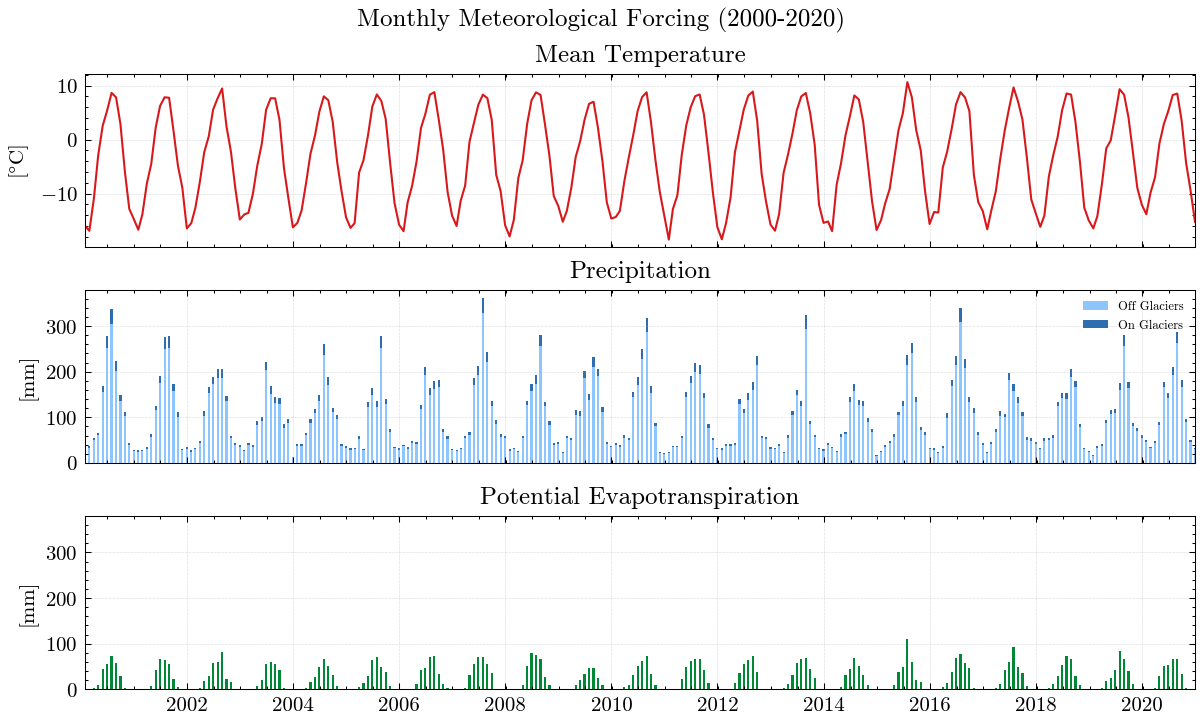

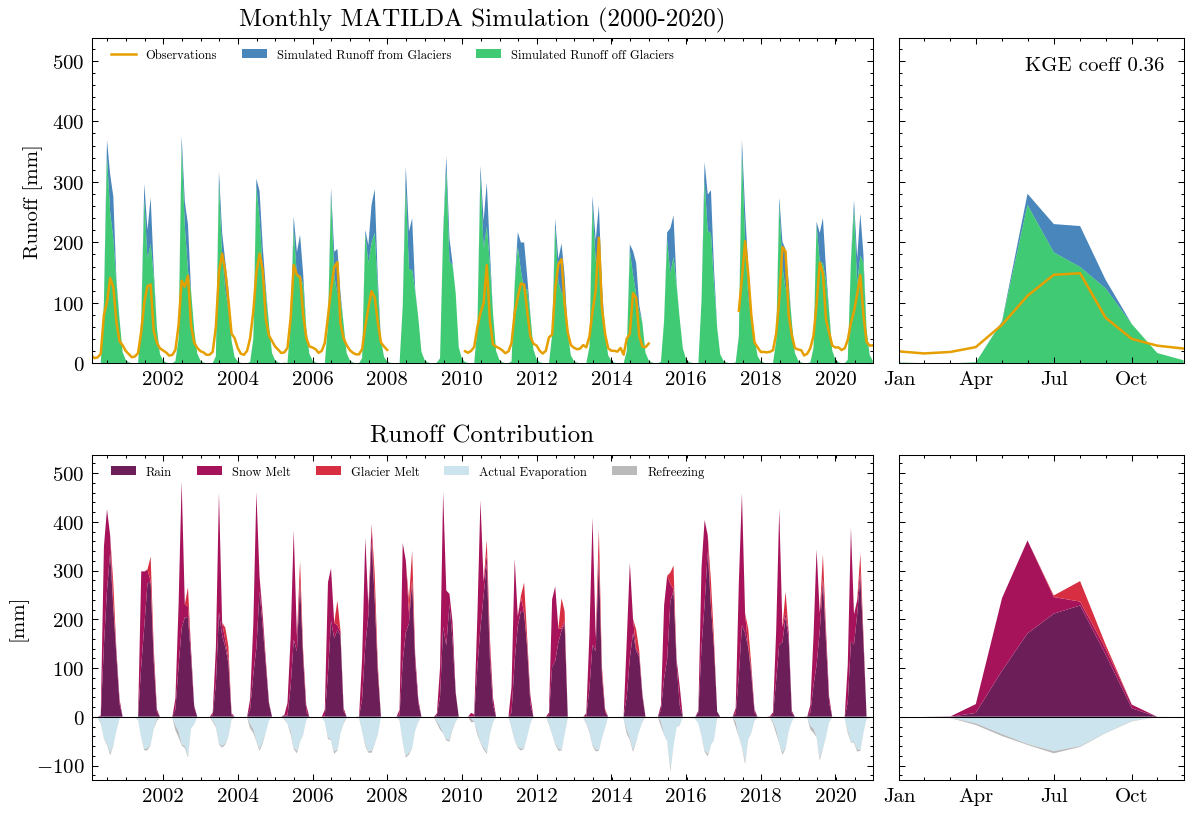

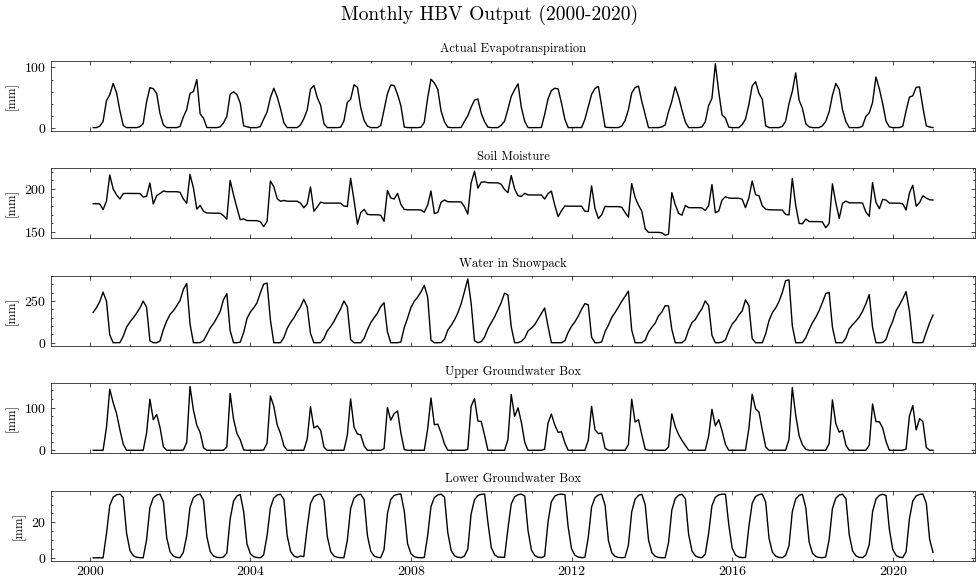

In [5]:
from matilda.core import matilda_simulation

output_matilda = matilda_simulation(era5, obs, **settings)

The results are obviously far from reality and largely overestimate runoff. The **Kling-Gupta Efficiency coefficient ([KGE](https://doi.org/10.1029/2011WR010962))** rates the result as 0.36 with 1.0 being a perfect match with the observations. We can also see that the input precipitation is much higher than the total runoff. Clearly, **the model needs calibration**.

## Calibrate MATILDA

In order to adjust the model parameters to the catchment characteristics, we will perform an **automated calibration**. The [MATILDA Python package](https://github.com/cryotools/matilda) contains a calibration module called *[matilda.mspot](https://github.com/cryotools/matilda/blob/master/matilda/mspot_glacier.py)* that makes extensive use of the Statistical Parameter Optimization Tool for Python ([SPOTPY](https://doi.org/10.1371/journal.pone.0145180)). As we have seen, there can be large uncertainties in the input data (especially precipitation). Simply tuning the model parameters to match the observed hydrograph may over- or underestimate other runoff contributors, such as glacier melt, to compensate for deficiencies in the precipitation data. Therefore, it is good practice to include additional data sets in a **multi-objective calibration**. In this workflow we will use:

- remote sensing estimates of **glacier surface mass balance** (**SMB**) and ...

- **snow water equivalent** (**SWE**) estimates from a dedicated snow reanalysis product.

Unfortunately, both default datasets are **limited to High Mountain Asia (HMA)**. For study sites in other areas, please consult other sources and manually add the target values for calibration in the appropriate code cells. We are happy to include additional datasets as long as they are available online and can be integrated into the workflow.

<div class="alert alert-block alert-info">
<b>Note:</b> Statistical parameter optimization (SPOT) algorithms require a high number of model runs, especially for large parameter sets. Both <i>mybinder.org</i> and <i>Google Colab</i> offer a maximum of two cores per user. One MATILDA calibration run for 20 years takes roughly 3s on one core. Therefore, large optimization runs in an online environment will be slow and may require you to leave the respective browser tab in the foreground for hours. To speed things up, you can either:

<div style="margin-left: 20px; margin-top: 12px;">
    ... run this notebook <b>locally on a computer with more cores</b> (ideally a high performance cluster) or <br>
    ... <b>reduce the number of calibration parameters</b> based on global sensitivity. We will return to this topic <a href="#Sensitivity-Analysis-with-FAST">later in this notebook</a>.
</div>
</div>

For now, we will demonstrate how to use the SPOT features and then **continue with a parameter set from a large HPC optimization run**. If you need help implementing the routine on your HPC, consult the [SPOTPY documentation](https://spotpy.readthedocs.io/en/latest/Advanced_hints/#mpi-parallel-computing) and [contact us](https://github.com/phiscu/matilda_edu/issues/new) if you encounter problems.

### Glacier surface mass balance data

There are various sources of SMB records but only remote sensing estimates provide data for (almost) all glaciers in the target catchment. [Shean et. al. 2020 ](https://doi.org/10.3389/feart.2019.00363) calculated geodetic mass balances for all glaciers in High Mountain Asia from 2000 to 2018. For this example (and all other catchments in HMA), we can use their data set so derive an average annual mass balance in the calibration period.

<div class="alert alert-block alert-info">
<b>Note:</b> As all remote sensing estimates the used dataset has significant uncertainties. A comparison to other datasets and the impact on the modeling results are discussed in the associated publication. </div>

We pick all individual mass balance records that match the glacier IDs in our catchment and calculate the catchment-wide mean. In addition, we use the uncertainty estimate provided in the dataset to derive an uncertainty range.

In [6]:
import pandas as pd

mass_balances = pd.read_csv(dir_input + '/hma_mb_20190215_0815_rmse.csv', usecols=['RGIId', 'mb_mwea', 'mb_mwea_sigma'])
ids = pd.read_csv(dir_output + '/RGI/Glaciers_in_catchment.csv')

merged = pd.merge(mass_balances, ids, on='RGIId')
mean_mb = round(merged['mb_mwea'].mean() * 1000, 3)   # Mean catchment MB in mm w.e.
mean_sigma = round(merged['mb_mwea_sigma'].mean() * abs(mean_mb), 3)  # Mean uncertainty of catchment MB in mm w.e.

target_mb = [mean_mb - mean_sigma, mean_mb + mean_sigma]

print('Target glacier mass balance for calibration: ' + str(mean_mb) + ' +-' + str(mean_sigma) + 'mm w.e.')

Target glacier mass balance for calibration: -155.474 +-50.3mm w.e.


### Snow water equivalent

For snow cover estimates, we will use a specialized **snow reanalysis** dataset from [Liu et. al. 2021](https://doi.org/10.5067/HNAUGJQXSCVU). Details on the data can be found in the dataset documentation and the associated [publication](https://doi.org/10.1029/2022GL100082).
Unfortunately, access to the dataset requires a (free) registration at **NASA's EarthData** portal, which prevents a seamless integration. Also, the dataset consists of large files and requires some pre-processing that **could not be done in a Jupyter Notebook**. However, we provide you with the `SWEETR` tool, a **fully automated workflow** that you can run on your local computer to download, process, and aggregate the data. Please refer to the dedicated [Github repository](https://github.com/phiscu/hma_snow) for further instructions.

<img src="images/mean_swe_example.png" alt="Mean_SWE" width="400">

When you run the `SWEETR` tool with your catchment outline, it returns cropped raster files as the one shown above and, more importantly, a **timeseries of catchment-wide daily mean SWE** from 1999 to 2016. Just replace the `input/swe.csv` file with your result. Now we can load the timeseries as a dataframe.

In [7]:
swe = pd.read_csv(f'{dir_input}/swe.csv')

Along with the cropped SWE rasters the `SWEETR` tool creates binary masks for seasonal- and non-seasonal snow. Due to its strong signal in remote sensing data, seasonal snow can be better detected leading to more robust SWE estimates. However, the non-seasonal snow largely agrees with the glacierized area. Therefore, we will calibrate the snow routine by comparing the SWE of the ice-free sub-catchment with the seasonal snow of the reanalysis. Since the latter has a coarse resolution of 500 m, the excluded catchment area is a bit larger than the RGI glacier outlines (17.2% non-seasonal snow vs. 10.8% glacierized sub-catchment). Therefore, we use a scaling factor to account for this mismatch in the reference area.

In [8]:
glac_ratio = settings['area_glac'] / settings['area_cat']       # read glacieriezed and total area from the settings
swe_area_sim = 1-glac_ratio
swe_area_obs = 0.828            # 1 - non-seasonal snow / seasonal snow
sf = swe_area_obs / swe_area_sim
print('SWE scaling factor: ' + str(round(sf, 3)))

SWE scaling factor: 0.928


The MATILDA framework provides an interface for [SPOTPY](https://github.com/thouska/spotpy/). Here we will use the `psample()` function to run MATILDA with the same settings as before but varying parameters. To do this, we will remove redundant `settings` and add some new ones specific to the function. Be sure to choose the number of repetitions carefully.

In [9]:
from tools.helpers import drop_keys

psample_settings = drop_keys(settings, ['warn', 'plots', 'plot_type'])

additional_settings = {'rep': 10,                             # Number of model runs. For advice, check the documentation of the algorithms.
                       'glacier_only': False,                 # True when calibrating an entirely glacierized catchment
                       'obj_dir': 'maximize',                 # Maximize (e.g. NSE) or minimize (e.g. RMSE) the objective function 
                       'target_mb': mean_mb,                  # Average annual glacier mass balance to target at
                       'target_swe': swe,                     # Catchment-wide mean SWE timeseries of seasonal snow to calibrate the snow routine
                       'swe_scaling': 0.928,                  # scaling factor for simulated SWE to account for reference area mismatch
                       'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql') or not ('None')
                       'output': None,                        # Choose where to store the files
                       'algorithm': 'lhs',                    # Select the algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                       'dbname': 'era5_matilda_example',      # Name the database
                       
                       'parallel': False,                     # Distribute the calculation on multiple cores or not
                      # 'cores': 20                           # Set number of cores when running in parallel
                      }
psample_settings.update(additional_settings)

print('Settings for calibration runs:\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

Settings for calibration runs:

area_cat: 295.67484249904464
area_glac: 31.829413146585885
ele_cat: 3293.491688025922
ele_dat: 3335.668840874115
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18280043250193
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
glacier_profile:      Elevation      Area          WE  EleZone  norm_elevation   delta_h
0         1970  0.000000      0.0000     1900        1.000000  1.003442
1         2000  0.000000      0.0000     2000        0.989324  0.945813
2         2100  0.000000      0.0000     2100        0.953737  0.774793
3         2200  0.000000      0.0000     2200        0.918149  0.632696
4         2300  0.000000      0.0000     2300        0.882562  0.515361
..         ...       ...         ...      ...             ...       ...
156       4730  0.000023  20721.3700     4700        0.017794 -0.000265
157       4740  0.000013  14450.2180     4700        0.014235 -0.000692
158       4750  0.0000

With these settings we can start `psample()` to run our model with various parameter combinations. The default parameter boundaries can be found in the MATILDA [parameter documentation](https://github.com/cryotools/matilda/tree/master?tab=readme-ov-file#parameter-list). If you want to narrow down the parameter space, you can do that using the following syntax. Here, we define custom ranges for the temperature lapse rate and the precipitation correction factor and run a short Latin Hypercube Sampling (LHS) for demonstration.

In [10]:
from matilda.mspot_glacier import psample

lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}

best_summary = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
1 of 10, maximal objective function=-0.722095, time remaining: 00:00:08
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 10, maximal objective function=-0.0765382, time remaining: 00:00:10
3 of 10, maximal objective function=-0.0765382, time remaining: 00:00:10
4 of 10, maximal objective function=0.187639, time remaining: 00:00:09
5 of 10, maximal objective function=0.231071, time remaining: 00:00:07
6 of 10, maximal objective function=0.231071, time remaining: 00:00:06
7 of 10, maximal objective function=0.349522, time remaining: 00:00:04
8 of 10, maximal objective function=0.349522, time remaining: 00:00:02
9 of 10, maximal objective function=0.357921, time remaining: 00:00:00
10 of 10, maximal objective function=0.357921, time remaining: 23:59:58

*** Final SPOTP

In this example the function ran the model 10 times with different parameter sets and returned the one with the highest KGE score. It can be accessed from the results dictionary.

In [11]:
best_parameterset = best_summary['best_param']
# Rounding all values for readability
rounded_parameters = {key: round(value, 3) for key, value in best_parameterset.items()}
print(rounded_parameters)

{'lr_temp': -0.005, 'lr_prec': 0.002, 'BETA': 4.16, 'CET': 0.033, 'FC': 250.273, 'K0': 0.105, 'K1': 0.053, 'K2': 0.068, 'LP': 0.563, 'MAXBAS': 6.722, 'PERC': 1.614, 'UZL': 470.349, 'PCORR': 0.875, 'TT_snow': 1.15, 'TT_diff': 0.717, 'CFMAX_snow': 4.065, 'CFMAX_rel': 1.217, 'SFCF': 0.78, 'CWH': 0.127, 'AG': 0.54, 'CFR': 0.227}


Of course, to properly cover the full parameter space you would need way more repetitions. However, a high number of samples and a high KGE score don't necessarily give you the parameter set that describes the features of your catchment the best. To find the parameter combination most suitable to simulate the processes governing streamflow, we propose to calibrate MATILDA in several steps.

## Process-based calibration

Every parameter governs a different aspect of the water balance, and not all parameters affect every calibration variable. Therefore, we propose an **iterative process-based calibration** approach where we calibrate parameters in order of their importance using different algorithms, objective functions, and calibration variables. Details on the calibration strategy can be found in the model publication which is currently under review. Here, we only provide code examples with 10 samples per step for demonstration purposes. For ideal number of samples please refer to the associated publication.

<img src="images/calibration_strategy.png" alt="calibration" width="300">


### Step 1: Input correction

Three HBV parameters correct for errors in the input precipitation, snowfall, and evaporation data. They have by far the largest impact on simulated runoff and must be corrected first. The correction factors are primarily designed to correct for observational errors, such as undercatch of solid precipitation. The best way to determine these parameters depends on your study site and available observations. In this example, we 'turn off' the correction factors for snowfall (`SFCF=0`) and evaporation (`CET=0`), leaving the input data unchanged, to focus on the model's internal sensitivities rather than the input data sets. However, the ERA5-Land dataset overestimates precipitation frequency and amounts in mountainous regions. A comparison of the monthly summer precipitation (Apr-Sep) with the in-situ observations from 2008 to 2017 showed that ERA5-Land overestimates the total precipitation in the example catchment by more than 100% (`108±62%`). Since the precipitation correction factor (`PCORR`) was identified as the most influential parameter, we cannot avoid to carefully calibrate it to obtain realistic runoff rates.

To constrain `PCORR`, we split the remaining 19 parameters into two subsets: (1) parameters governing the water balance, and (2) those controlling runoff timing, with the latter set to default values. The results can then be filtered sequentially based on thresholds for $MAE_{smb}$, $KGE_{swe}$, and subsequently $KGE_{r}$. `PCORR` was set to the mean value of the posterior distribution for subsequent calibration steps.

<div style="margin-left: 20px; margin-top: 12px;">
    (1) parameters governing the water balance, and<br>
    (2) those controlling runoff timing,
</div>

First, we edit the settings to write results to a `.csv` file and run random sampling for the parameter subset governing the runoff amount while fixing all other parameters.

In [12]:
# Edit the settings to write results in a .csv file
psample_settings['dbformat'] = 'csv'
psample_settings['output'] = dir_output
psample_settings['dbname'] = 'calib_step1'

# Run random sampling
step1_summary = psample(
            df=era5, obs=obs, **psample_settings,
			fix_param=['SFCF', 'CET', 'FC', 'K0', 'K1', 'K2', 'MAXBAS', 'PERC', 'UZL', 'CWH', 'AG', 'LP', 'CFR'],    # fixed on defaults
			fix_val={'SFCF': 1, 'CET': 0}                                                                            # fixed on specific values
		       )

Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
1 of 10, maximal objective function=-0.988693, time remaining: 00:00:09
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_step1.csv' created.
2 of 10, maximal objective function=-0.988693, time remaining: 00:00:10
3 of 10, maximal objective function=0.182525, time remaining: 00:00:10
4 of 10, maximal objective function=0.182525, time remaining: 00:00:09
5 of 10, maximal objective function=0.182525, time remaining: 00:00:07
6 of 10, maximal objective function=0.182525, time remaining: 00:00:06
7 of 10, maximal objective function=0.258956, time remaining: 00:00:04
8 of 10, maximal objective function=0.258956, time remaining: 00:00:02
9 of 10, maximal objective function=0.258956, time remaining: 00:00:00
10 of 10, maximal objective function=0.427425, t

Next, we load the samples from the `.csv` file and can apply appropriate filters to the data.

In [13]:
step1_samples = pd.read_csv(f"{dir_output}calib_step1.csv")

step1_samples = step1_samples.drop(['chain'], axis=1)
step1_samples.columns = ['KGE_Runoff', 'MAE_SMB', 'KGE_SWE'] + list(step1_samples.columns[3:])
step1_samples.columns = step1_samples.columns.str.replace('par', '')

# Apply appropriate filters
#step1_samples = step1_samples[step1_samples['KGE_Runoff'] > 0.5]
#step1_samples = step1_samples[step1_samples['MAE_SMB'] < 100]
#step1_samples = step1_samples[step1_samples['KGE_SWE'] > 0.8]

print(step1_samples)

FileNotFoundError: [Errno 2] No such file or directory: 'output/calib_step1.csv'

We then plot the posterior distributions for each parameter. *Note: For very few samples they are likely to look very similar.*

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Create a 2x4 matrix of subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

# Plot posterior distributions for each parameter in the matrix of subplots
for i, parameter in enumerate(step1_samples.columns[3:]):  # Exclude the first two columns
    row = i // 4
    col = i % 4
    sns.kdeplot(step1_samples[parameter], fill=True, ax=axs[row, col])
    axs[row, col].set_xlabel(None)
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_title(f'{parameter}', fontweight='bold', fontsize=14)
    if parameter in [step1_samples.columns[3], step1_samples.columns[4]]:
        def format_ticks(x, _):
            return '{:.0f}e-4'.format(x * 10000)  # Adjust multiplier here for desired scientific notation
        axs[row, col].xaxis.set_major_formatter(FuncFormatter(format_ticks))
    # Add vertical lines for mean, mean ± standard deviation
    mean_val = step1_samples[parameter].mean()
    std_val = step1_samples[parameter].std()
    axs[row, col].axvline(mean_val, color='red', linestyle='--', label='Mean')

plt.tight_layout()
plt.show()

Finally, we calculate the mean and standard deviation for each parameter and write the results to a table.

In [ ]:
# Calculate mean and standard deviation for each column (excluding first two and last column)
stats_dict = {}
for col in step1_samples.columns[2:]:
    mean = step1_samples[col].mean()
    std = step1_samples[col].std()
    stats_dict[col + "_mean"] = round(mean, 5)
    stats_dict[col + "_stddev"] = round(std, 5)

# Write to table
table_step1_samples = []
for col in step1_samples.columns[:]:
    mean = step1_samples[col].mean()
    std = step1_samples[col].std()
    table_step1_samples.append([round(mean, 5), round(std, 5)])

table_df = pd.DataFrame(table_step1_samples, columns=['Mean', 'Stdv'], index=step1_samples.columns)
print(table_df)

With an appropriate number of samples, these values will give you a good idea of the parameter distribution. In our example study, we'll fix `PCORR` and few insensitive parameters (`lr_temp`, `lr_prec`, `RFS`; see the <a href="#Sensitivity-Analysis-with-FAST">Sensitivity Section</a> for details) on their mean values and use the standard deviation of the other parameters to define the bounds for subsequent calibration steps.

### Step 2: Snow routine calibration

In [ ]:
best_summary = psample(
                df=era5, obs=obs, **psample_settings,
		        fix_param=['PCORR', 'SFCF', 'CET', 'lr_temp', 'lr_prec', 'K0', 'LP', 'MAXBAS', 'CFMAX_rel', 'RFS', 'FC', 'K1', 'K2', 'PERC', 'UZL', 'CWH', 'AG', 'BETA'],
		        fix_val={'PCORR': 0.58, 'SFCF': 1, 'CET': 0, 'lr_temp': -0.0061, 'lr_prec': 0.0015, 'RFS': 0.15},
		       )

## Run MATILDA with calibrated parameters

The following parameter set was computed applying the mentioned calibration strategy on an HPC cluster.
<a id="param"></a>

In [ ]:
param = {
    'RFS': 0.15,
    'SFCF': 1,
    'CET': 0,
    'PCORR': 0.58,
    'lr_temp': -0.006,
    'lr_prec': 0.0015,
    'TT_diff': 0.76198,
    'TT_snow': -1.44646,
    'CFMAX_snow': 3.3677,
    'BETA': 1.0,
    'FC': 99.15976,
    'K0': 0.01,
    'K1': 0.01,
    'K2': 0.15,
    'LP': 0.998,
    'MAXBAS': 2.0,
    'PERC': 0.09232826,
    'UZL': 126.411575,
    'CFMAX_rel': 1.2556936,
    'CWH': 0.000117,
    'AG': 0.54930484
}

print('Calibrated parameter set:\n\n')
for key in param.keys(): print(key + ': ' + str(param[key]))

Properly calibrated, the model shows a much better results.

In [ ]:
output_matilda = matilda_simulation(era5, obs, **settings, **param)

In addition to the standard plots we can explore the results interactive `ploty` plots. Go ahead and zoom as you like or select/deselect individual curves.

In [ ]:
output_matilda[9].show()

The same works for the long-term seasonal cycle.

In [ ]:
output_matilda[10].show()

## Sensitivity Analysis with FAST

To reduce the computation time of the calibration procedure, we need to reduce the number of parameters to be optimized. Therefore, we will perform a global sensitivity analysis to identify the most important parameters and set the others to default values. The algorithm of choice will be the [Fourier Amplitude Sensitivity Test (FAST)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594) available through the [SPOTPY](https://github.com/thouska/spotpy/blob/master/src/spotpy/algorithms/fast.py) library. As before, we will show the general procedure with a few iterations, but display results from extensive runs on a HPC. You can use the results as a guide for your parameter choices, but keep in mind that they are highly correlated with your catchment properties, such as elevation range and glacier coverage.

First, we calculate the required number of iterations using a formula from [Henkel et. al. 2012](https://www.informs-sim.org/wsc12papers/includes/files/con308.pdf). We choose the SPOTPY default frequency step of 2 and set the interference factor to a maximum of 4, since we assume a high intercorrelation of the model parameters. The total number of parameters in MATILDA is 21.

In [ ]:
def fast_iter(param, interf=4, freqst=2):
    """
    Calculates the number of parameter iterations needed for parameterization and sensitivity analysis using FAST.
    Parameters
    ----------
    param : int
        The number of input parameters being analyzed.
    interf : int
        The interference factor, which determines the degree of correlation between the input parameters.
    freqst : int
        The frequency step, which specifies the size of the intervals between each frequency at which the Fourier transform is calculated.
    Returns
    -------
    int
        The total number of parameter iterations needed for FAST.
    """
    return (1 + 4 * interf ** 2 * (1 + (param - 2) * freqst)) * param

print('Needed number of iterations for FAST: ' + str(fast_iter(21)))

That is a lot of iterations! Running this routine on a single core would take about two days, but can be sped up significantly with each additional core. The setup would look exactly like the parameter optimization before.

**Note:** No matter what number of iterations you define, SPOTPY will run $N*k$ times, where $k$ is the number of model parameters. So even if we set `rep=10`, the algorithm will run at least 21 times.

In [ ]:
from matilda.mspot_glacier import psample

fast_settings = {'rep': 52437,                              # Choose wisely before running
                 'target_mb': None,
                 'algorithm': 'fast',
                 'dbname': 'fast_matilda_example',
                 'dbname': dir_output + 'fast_example',
                 'dbformat': 'csv'
                      }
psample_settings.update(fast_settings)

print('Settings for FAST:\n\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

# fast_results = psample(df=era5, obs=obs, **psample_settings)

We ran *FAST*s for the example catchment with the full number of iterations required. The results are saved in *CSV* files. We can use the `spotpy.analyser` library to create easy-to-read data frames from the databases. The summary shows the first (`S1`) and the total order sensitivity index (`ST`) for each parameter. `S1` refers to the variance of the model output explained by the parameter, holding all other parameters constant. The `ST` takes into account the interaction of the parameters and is therefore a good measure of the impact of individual parameters on the model output.

In [ ]:
import spotpy
import os
import contextlib

def get_si(fast_results: str, to_csv: bool = False) -> pd.DataFrame:
    """
    Computes the sensitivity indices of a given FAST simulation results file.
    Parameters
    ----------
    fast_results : str
        The path of the FAST simulation results file.
    to_csv : bool, optional
        If True, the sensitivity indices are saved to a CSV file with the same
        name as fast_results, but with '_sensitivity_indices.csv' appended to
        the end (default is False).
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the sensitivity indices and parameter
        names.
    """
    if fast_results.endswith(".csv"):
        fast_results = fast_results[:-4]  # strip .csv
    results = spotpy.analyser.load_csv_results(fast_results)
    # Suppress prints
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        SI = spotpy.analyser.get_sensitivity_of_fast(results, print_to_console=False)
    parnames = spotpy.analyser.get_parameternames(results)
    sens = pd.DataFrame(SI)
    sens['param'] = parnames
    sens.set_index('param', inplace=True)
    if to_csv:
        sens.to_csv(os.path.basename(fast_results) + '_sensitivity_indices.csv', index=False)
    return sens

display(get_si(dir_input + 'FAST/' + 'example_fast_nolim.csv'))

If you have additional information on certain parameters, limiting their bounds can have a large impact on sensitivity. For our example catchment, field observations showed that the temperature lapse rate and precipitation correction were unlikely to exceed a certain range, so we limited the parameter space for both and ran a *FAST* again.

In [ ]:
lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}
# fast_results = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

To see the effect of parameter restrictions on sensitivity, we can plot the indices of both runs. Feel free to explore further by adding more *FAST* outputs to the plot function.

In [ ]:
import plotly.graph_objs as go
import pandas as pd
import plotly.io as pio

def plot_sensitivity_bars(*dfs, labels=None, show=False, bar_width=0.3, bar_gap=0.6):
    """
    Plots a horizontal bar chart showing the total sensitivity index for each parameter in a MATILDA model.

    Parameters
    ----------
    *dfs : pandas.DataFrame
        Multiple dataframes containing the sensitivity indices for each parameter.
    labels : list of str, optional
        Labels to use for the different steps in the sensitivity analysis. If not provided, the default
        labels will be 'No Limits', 'Step 1', 'Step 2', etc.
    bar_width : float, optional
        Width of each bar in the chart.
    bar_gap : float, optional
        Space between bars.
    """
    traces = []
    colors = ['darkblue', 'orange', 'purple', 'cyan']   # add more colors if needed
    for i, df in enumerate(dfs):
        df = get_si(df)
        if i > 0:
            if labels is None:
                label = 'Step ' + str(i)
            else:
                label = labels[i]
        else:
            label = 'No Limits'
        trace = go.Bar(y=df.index,
                       x=df['ST'],
                       name=label,
                       orientation='h',
                       marker=dict(color=colors[i]),
                       width=bar_width)
        traces.append(trace)
    layout = go.Layout(title=dict(text='<b>' +'Total Sensitivity Index for MATILDA Parameters' + '<b>', font=dict(size=24)),
                   xaxis_title='Total Sensitivity Index',
                   yaxis_title='Parameter',
                   yaxis=dict(automargin=True),
                   bargap=bar_gap,
                   height=700)
    fig = go.Figure(data=traces, layout=layout)
    if show:
        fig.show()
        
step1 = dir_input + 'FAST/' + 'example_fast_nolim.csv'
step2 = dir_input + 'FAST/' + 'era5_ipynb_fast_step1.csv'

plot_sensitivity_bars(step1, step2, labels=['No Limits', 'lr_temp and PCORR limited'], show=True)

From this figure, we can easily identify the most important parameters. Depending on your desired accuracy and computational resources, you can choose a sensitivity threshold. Let's say we want to fix all parameters with a sensitivity index below 0.1. For our example, this will reduce the calibration parameters to 7.

In [ ]:
si_df = get_si(step2)
sensitive = si_df.index[si_df['ST'] > 0.10].values

print('Parameters with a sensitivity index > 0.1:')
for i in sensitive: print(i)

To give you an idea how much this procedure can reduce calibration time, we run the `fast_iter()` function again.

In [ ]:
print('Needed number of iterations for FAST with all parameters: ' + str(fast_iter(21)))
print('Needed number of iterations for FAST with the 7 most sensitive parameters: ' + str(fast_iter(7)))

For a single core this would roughly translate into a reduction from 44h to 4h.

To run the calibration with the reduced parameter space, we simply need to define values for the fixed parameters and use a helper function to translate them into boundary arguments. Here we simply use the values from our last *SPOTPY* run (`param`).

In [ ]:
from matilda.mspot_glacier import dict2bounds

fixed_param = {key: val for key, val in param.items() if key not in sensitive}
fixed_param_bounds = dict2bounds(fixed_param)
       
print('Fixed bounds:\n')
for key in fixed_param_bounds.keys(): print(key + ': ' + str(fixed_param_bounds[key]))

The `psample()` setup is then as simple as before.

In [ ]:
new_settings = {'rep': 10,                             # Number of model runs. For advice check the documentation of the algorithms.
                'glacier_only': False,                 # True when calibrating a entirely glacierized catchment
                'obj_dir': 'maximize',                 # should your objective funtion be maximized (e.g. NSE) or minimized (e.g. RMSE)
                'target_mb': -156,                     # Average annual glacier mass balance to target at
                'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql')
                'output': None,                        # Choose where to store the files
                'algorithm': 'lhs',                    # Choose algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                'dbname': 'era5_matilda_example',      # Choose name
                       
                'parallel': False,                     # Distribute the calculation on multiple cores or not
                # 'cores': 20                           # Set number of cores when running parallel
                      }
psample_settings.update(new_settings)

best_summary = psample(df=era5, obs=obs, **psample_settings, **fixed_param_bounds)

<div class="alert alert-block alert-info">
<b>Note:</b> The number of iterations required depends on the selected algorithm and the number of free parameters. To choose the correct setting, consult the <a href='https://spotpy.readthedocs.io/en/latest/Algorithm_guide/'>SPOTPY documentation</a> and the original literature for each algorithm.</div>

Now, we save the best parameter set for use in the next notebook. The set is stored in the `best_summary` variable.

**Note:** In our example we will skip this step and use the [result from the calibration on an HPC cluster](#param).

In [ ]:
# param = best_summary['best_param']

Finally, we store the parameter set in a `.yml` file.

In [ ]:
write_yaml(param, dir_output + 'parameters.yml')
print(f"Parameter set stored in '{dir_output}parameters.yml'")

In [ ]:
import shutil

# refresh `output_download.zip` with data retrieved within this notebook
shutil.make_archive('output_download', 'zip', 'output')
print('Output folder can be download now (file output_download.zip)')

In [ ]:
%reset -f